In [18]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import numpy as np
import skimage.io as io

from copy import deepcopy

from PIL import Image

from scipy.signal import convolve2d

import cv2

from datetime import datetime, timedelta

import time


#https://data.phys.ucalgary.ca/sort_by_project/TREx/RGB/stream2

loading data

In [19]:
year = "2022" #2020
month = "02" #04
day = "04"#"05"
site = "gill_rgb-04"

mnt_dir = "/mnt/ceph"

bender_dir= "/trex/rgb/stream2/" #where we are getting the data from 

#for now only looking at one photo
time = "10"#"07"


file_path = "%s%s%s/%s/%s/%s/ut%s/" % (mnt_dir, bender_dir,year, month, day, site,time)

print(file_path)

file_name = "%s%s%s_%s_%s_full-keogram.jpg" % (year,month,day,time, site)
  
full_file_path = file_path + file_name

print(full_file_path)

/mnt/ceph/trex/rgb/stream2/2022/02/04/gill_rgb-04/ut10/
/mnt/ceph/trex/rgb/stream2/2022/02/04/gill_rgb-04/ut10/20220204_10_gill_rgb-04_full-keogram.jpg


display inishal image 

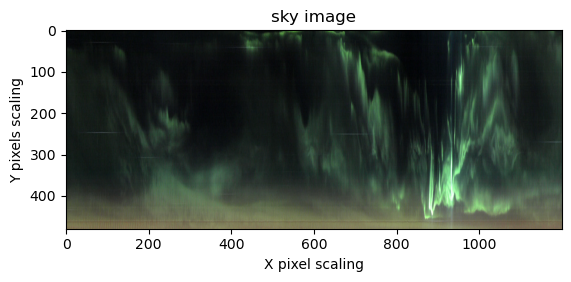

In [20]:
plt.title("sky image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")

image = mpimg.imread(full_file_path)
plt.imshow(image)
plt.show()


Pick out only white pickels 

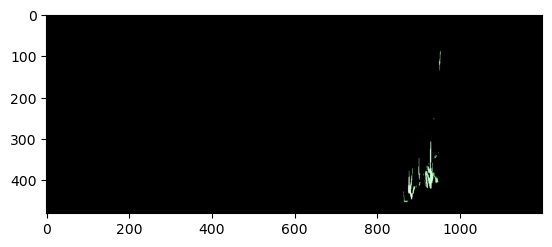

In [21]:
#load image 
image = Image.open(full_file_path)

#convert image to np array 
RGB_array = np.array(image)

# selecting a disired color we want 
white = np.array([255,255,255])

#an array of the same size that consists off how off we are in our color selection 
diff = np.abs(RGB_array - white)

# take the summ of the colors in the dirrece array, and if it is less then and arbatray constant and put true into that new array 
white_mask = np.sum(diff, axis=2)<200 # get the sum of the colors (z dimmentiotn)
#now have a (L by W) array saying if that area is a valid area

#make a copy for the white color 
white_channel = np.zeros_like(RGB_array)
white_channel[white_mask] = RGB_array[white_mask]


# for prinitng the image 
white_image = Image.fromarray(white_channel)
plt.imshow(white_image)

revomove individual white spots

In [22]:
num_true_values_inishal = white_mask[white_mask]
print(num_true_values_inishal.size)

# if there is just one white point on its own, erase it 
for x in range(1, white_mask.shape[0]-1):
    for y in range(1, white_mask.shape[1]-1):
        if white_mask[x,y] and \
        not white_mask[x,y+1] and \
        not white_mask[x,y-1] and \
        not white_mask[x-1,y] and \
        not white_mask[x+1,y] and \
        not white_mask[x+1,y+1] and \
        not white_mask[x-1,y+1] and \
        not white_mask[x+1,y-1] and \
        not white_mask[x-1,y-1]:
            white_mask[x,y] = False


1647


clustering white spots useing BFS algerithum

In [23]:
matrix = white_mask.astype(int) #matrix is made into intigers 

dx = [+1, 0, -1, 0]
dy = [0, +1, 0, -1]

h, w = matrix.shape # shape of matrix

label = np.zeros((h, w)) #new matrix is made with that shape to track if a position has been visated 

clusters = {} #dictionalry represenitng all the culsters 
component = 1 #used to lable the cluster 

for i in range(h): # loop threw matrix 
    for j in range(w):
        if matrix[i][j] != 0 and label[i][j] == 0: #if we get a an unvisited componet, new cluster is started 
            cluster = []
            queue = [(i, j, component)]
            while queue: #use breth search first algerithum, queue is starts at the starting position and goes untill there is nothing in it anymopre  
                x, y, component = queue.pop(0) #explore the next elemnt in the queue 
                if 0 <= x < h and 0 <= y < w and label[x][y] == 0 and matrix[x][y] != 0: #check if valid (in bounds, has not been vitited, non zero value )
                    label[x][y] = component #mareked as visited
                    cluster.append((x,y)) # add value to the list 
                    
                    
                    for direction in range(len(dx)): # adds all the nebors to the queue 
                        queue.append([x+dx[direction],   y+dy[direction], component])
            clusters[component] = cluster # add list to dictionaly 
            component += 1 # go to the next componet 

print(clusters)

{1: [(89, 954), (90, 954), (91, 954), (92, 954), (93, 954), (94, 954), (93, 953), (95, 954), (94, 953), (95, 953), (96, 953), (97, 953), (98, 953), (99, 953), (98, 954), (100, 953), (101, 953), (102, 953), (103, 953), (104, 953), (105, 953), (106, 953), (107, 953), (108, 953), (109, 953), (110, 953), (109, 952), (111, 953), (110, 952), (111, 952), (112, 952), (113, 952), (114, 952), (115, 952), (114, 953), (114, 951), (116, 952), (115, 953), (115, 951), (117, 952), (116, 953), (116, 951), (118, 952), (117, 953), (117, 951), (119, 952), (118, 953), (118, 951), (120, 952), (119, 951), (121, 952), (120, 951), (122, 952), (121, 951), (123, 952), (122, 951), (124, 952), (125, 952), (126, 952), (127, 952), (128, 952), (129, 952), (130, 952), (131, 952), (132, 952), (133, 952), (134, 952), (135, 952)], 2: [(251, 938), (252, 938), (253, 938)], 3: [(307, 930), (308, 930), (309, 930), (308, 931), (310, 930), (309, 931), (311, 930), (310, 931), (312, 930), (311, 931), (313, 930), (312, 931), (314

for displaying the clusters

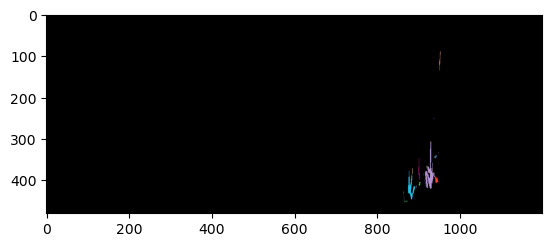

In [24]:
out_put_img = np.zeros_like(RGB_array)

colors = {}

for i, c in enumerate(clusters.values()):
    color = np.random.randint(20, 256, size=3)
    colors[i+1]= color
    for x, y in c:
        out_put_img[x, y] = color

plt.imshow(out_put_img)
plt.show()

checking Differnt conditions

In [25]:
#true if there is a spotting
spotting = False

# is spotting is true then why we think there is a spotting 
# if spotting is faluse then why we think there is no spotting
resoning = ""

# displays the UT time spotted if spotted is true 
# if spotted is faluse then displays -1
#time_spotted = ""
start_times = []
end_times = []

no white spots

In [26]:
# if there are no white spaces 
num_true_values_final = white_mask[white_mask]

if num_true_values_final.size==0 :
    resoning = "no white points detected"
    spotting = False


white spots take up more that 80% of the screen, not usable data 

In [27]:
# count the number off true values in true false array 
num_true = np.count_nonzero(white_mask)

#chekc if more that 80% of the screen is white "true valuse"
if num_true / white_mask.size > 0.8:
    resoning = str(num_true / white_mask.size * 100) + " percent of the screen is white, not useable data"
    spotting = False

remove clusters that are too small. and see if there are no more cluster

In [28]:
# remove clustrs that take up less that 0.001% off the screen 
print(len(clusters))
num_pixels = white_mask.size

for key in list(clusters.keys()):
    if len(clusters[key]) / num_pixels < 0.0005:
        del clusters[key] 

print(len(clusters))

#check if anything is left 
if len (clusters) == 0:
    resoning = "spotted white spots are too small."
    spotting = False

22
2


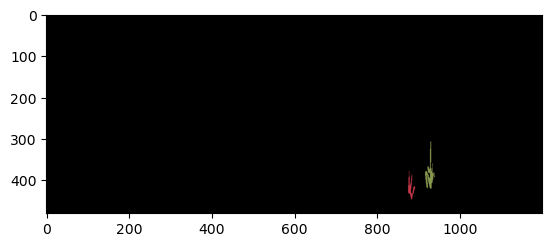

In [29]:
out_put_img = np.zeros_like(RGB_array)

colors = {}

for i, c in enumerate(clusters.values()):
    color = np.random.randint(20, 256, size=3)
    colors[i+1]= color
    for x, y in c:
        out_put_img[x, y] = color

plt.imshow(out_put_img)
plt.show()

remove clusters that are too large. and see if there are no more clusters 

In [30]:
# remove clustrs that take up more that 1% off the screen 
print(len(clusters))
num_pixels = white_mask.size

for key in list(clusters.keys()):
    if len(clusters[key]) / num_pixels > 0.003:
        del clusters[key]

print(len(clusters))

#check if anything is left 
if len (clusters) == 0:
    resoning += "spotted white spots are too large."
    spotting = False

2
2


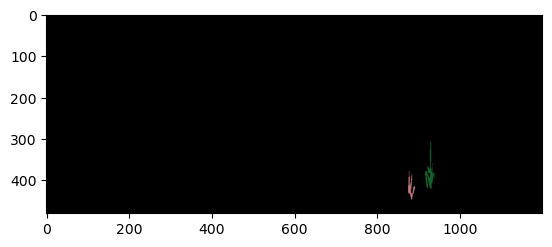

In [31]:
out_put_img = np.zeros_like(RGB_array)

colors = {}

for i, c in enumerate(clusters.values()):
    color = np.random.randint(20, 256, size=3)
    colors[i+1]= color
    for x, y in c:
        out_put_img[x, y] = color

plt.imshow(out_put_img)
plt.show()

if there are still clusters then we have made a detection. find the time. and display a cirure around what is found. 

In [32]:
if len (clusters) > 0:  
    resoning = "spotted white."
    spotting = True

    #find time range off all the differnt clusters 
    pixels_per_sec = 3

    #iterate threw all the different clusters 
    for commponet, point in clusters.items():

        min_x = None
        max_x = None

        for x, y in point:
            if min_x is None or x < min_x:
                min_x = x
            
            if max_x is None or x>max_x:
                max_x = x

        start_time_total = (min_x*pixels_per_sec)
        end_time_total = (max_x*pixels_per_sec)

        start_time_min = int(start_time_total //60)
        end_time_min = int(end_time_total //60)

        start_time_sec = start_time_total%60
        end_time_sec = end_time_total%60

        start_times.append(time + ":" + str(start_time_min) + ":" + str(start_time_sec))
        end_times.append(time + ":" + str(end_time_min) + ":" + str(end_time_sec))

print(start_times)
print(end_times)

['10:15:21', '10:18:54']
['10:21:3', '10:22:18']


Displaying the final image with a circlu area the white spot

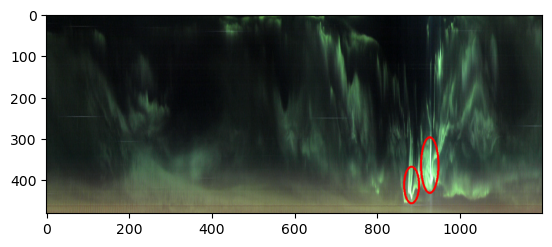

In [35]:
border_img = np.copy(RGB_array)

#draw borders arunf each cluster 
for cluster_points in clusters.values():

    # get top reight point
    x1 = min([point[0] for point in cluster_points])
    y1 = min([point[1] for point in cluster_points])

    #get bottom right 
    x2 = max([point[0] for point in cluster_points])
    y2 = max([point[1] for point in cluster_points])

    #get the center 
    center = ((y2 + y1)//2, (x2 + x1) //2)

    #size of ellipe 
    axes = ( (y2 - y1)//2 + 10, (x2 - x1)//2 +10  )

    # draw rectange arounf images 
    #cv2.rectangle(border_img, (y1,x1), (y2,x2), (255,0,0), 2)

    #draw ellips aroung center point with given size 
    cv2.ellipse(border_img, center, axes, 0, 0, 360, (255,0,0), 3)

plt.imshow(border_img) 
plt.show()


trying to display the time on the image 

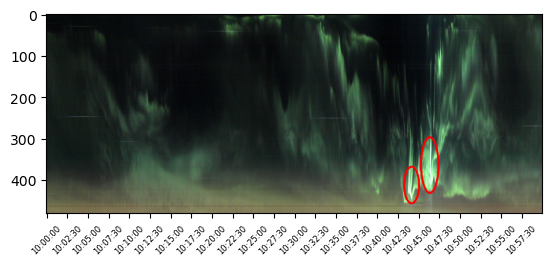

['10:00:00', '10:00:03', '10:00:06', '10:00:09', '10:00:12', '10:00:15', '10:00:18', '10:00:21', '10:00:24', '10:00:27', '10:00:30', '10:00:33', '10:00:36', '10:00:39', '10:00:42', '10:00:45', '10:00:48', '10:00:51', '10:00:54', '10:00:57', '10:01:00', '10:01:03', '10:01:06', '10:01:09', '10:01:12', '10:01:15', '10:01:18', '10:01:21', '10:01:24', '10:01:27', '10:01:30', '10:01:33', '10:01:36', '10:01:39', '10:01:42', '10:01:45', '10:01:48', '10:01:51', '10:01:54', '10:01:57', '10:02:00', '10:02:03', '10:02:06', '10:02:09', '10:02:12', '10:02:15', '10:02:18', '10:02:21', '10:02:24', '10:02:27', '10:02:30', '10:02:33', '10:02:36', '10:02:39', '10:02:42', '10:02:45', '10:02:48', '10:02:51', '10:02:54', '10:02:57', '10:03:00', '10:03:03', '10:03:06', '10:03:09', '10:03:12', '10:03:15', '10:03:18', '10:03:21', '10:03:24', '10:03:27', '10:03:30', '10:03:33', '10:03:36', '10:03:39', '10:03:42', '10:03:45', '10:03:48', '10:03:51', '10:03:54', '10:03:57', '10:04:00', '10:04:03', '10:04:06', '10

In [36]:
current_time_str = time + ':00:00'

current_time = datetime.strptime(current_time_str, '%H:%M:%S')

time_per_pixel= 3

width_image = RGB_array.shape[1]
length_image = RGB_array.shape[0]

times = []

for i in range(width_image):
    
    #time_str = current_time.strftime("%H:%M:%S")
    current_time_str = current_time.strftime('%H:%M:%S')
    times.append(current_time_str)
    current_time += timedelta(seconds=3)

plt.imshow(border_img) 

plt.xticks(range(0,width_image, 50), times[::50], rotation = 45, fontsize = 6)

plt.show()

print(times)

#ax.annotatte()

